# MLB Score Predictions (Ignore the repo name)

After looking through the dataset sizes, I decided this project would be cooler if there was more data available, so I opted to go with MLB over NFL data.

Here we'll be using features such as date, rating, team elo, to predict team scores for each game using regression models.

MLB Data Source: https://github.com/fivethirtyeight/data/tree/master/mlb-elo

## Loading, exploring, and cleaning the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

raw_data = pd.read_csv("./data/mlb_elo.csv")
raw_data.head()

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,...,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,rating1_post,rating2_post,score1,score2
0,2019-10-30,2019,0,w,HOU,WSN,1599.542804,1584.363378,0.574617,0.425383,...,56.920649,61.723620,0.989236,27.776342,0.515172,0.484828,1587.973463,1583.382133,2,6
1,2019-10-29,2019,0,w,HOU,WSN,1605.069000,1578.837182,0.595209,0.404791,...,62.975093,60.272516,28.723451,21.776276,0.594638,0.405362,1591.026009,1580.329587,2,7
2,2019-10-27,2019,0,w,WSN,HOU,1584.005206,1599.900976,0.515546,0.484454,...,49.433198,66.891460,-29.811205,47.888341,0.373102,0.626898,1576.189971,1595.165625,1,7
3,2019-10-26,2019,0,w,WSN,HOU,1589.985555,1593.920627,0.538425,0.461575,...,56.003581,51.251046,0.823752,-24.893480,0.586974,0.413026,1578.722119,1592.633477,1,8
4,2019-10-25,2019,0,w,WSN,HOU,1593.827376,1590.078806,0.553044,0.446956,...,54.036365,57.096801,-9.053908,2.440389,0.526852,0.473148,1583.715416,1587.640180,1,4


In [2]:
raw_data = raw_data.dropna()

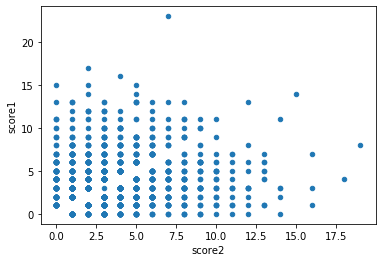

In [3]:
raw_data['date']=pd.to_datetime(raw_data['date'], infer_datetime_format = True).map(lambda t : dt.datetime.toordinal(t))
raw_data.head()
raw_data.plot.scatter(x="score2",y="score1")

^Interestingly, we have huge point value games. 30+ for both teams.

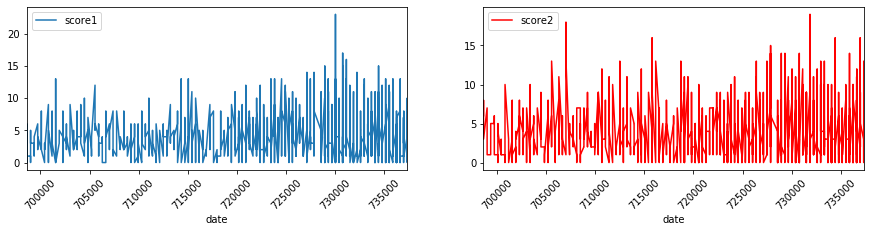

In [4]:
plt.figure(figsize=(15,3))
raw_data.plot(x="date",y="score1", ax = plt.subplot(121))
plt.xticks(rotation=45)
raw_data.plot(x="date",y="score2", ax = plt.subplot(122), c='red')
plt.xticks(rotation=45)
plt.show()
#Nothing too interesting about max score data over time (slightly larger max scores in old games)

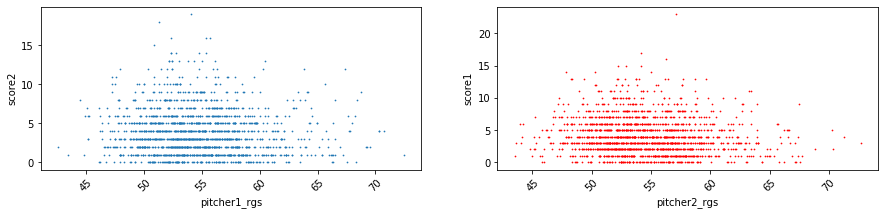

In [5]:
plt.figure(figsize=(15,3))
raw_data.plot.scatter(x="pitcher1_rgs",y="score2", s =.5, ax = plt.subplot(121))
plt.xticks(rotation=45)
raw_data.plot.scatter(x="pitcher2_rgs",y="score1", s =.5, ax = plt.subplot(122), c='red')
plt.xticks(rotation=45)
plt.show()
#This would look better as a heat map

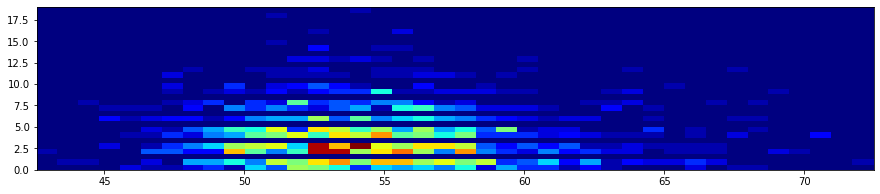

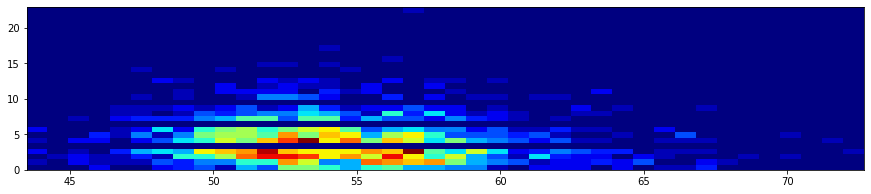

In [6]:
#Pitcher rolling game points allowed vs points allowed that game
plt.figure(figsize=(15,3))
p1_rgs = raw_data.query("pitcher1_rgs.notnull()", engine = 'python')
plt.hist2d(p1_rgs["pitcher1_rgs"], p1_rgs["score2"], bins=(40,30), density=True, cmap=plt.cm.jet)
plt.show()

plt.figure(figsize=(15,3))
p2_rgs = raw_data.query("pitcher2_rgs.notnull()", engine = 'python')
plt.hist2d(p1_rgs["pitcher2_rgs"], p1_rgs["score1"], bins=(40,30), density=True, cmap=plt.cm.jet)
plt.show()

## Features to engineer & Formatting
It'd be great to grab data like win streak, meta-analysis of 538's rating system, or even external data relating to the teams over time, but lets just start by adding a data like point differential, and point ratio 

In [7]:
eng = raw_data.copy()

# Simple encoding of playoff data
eng["playoff"] = eng["playoff"].map({'w':1, 'l':2, 'd':3, 'c':4, np.nan:5})

# Encode the team and player names
# eng = pd.get_dummies(eng, columns = ["team1", 'team2','pitcher1','pitcher2'], sparse = True) This is too much data to encode
eng = pd.get_dummies(eng, columns = ["team1", 'team2'], sparse = True)

# Add a relative score column
eng['delta'] = eng['score1']-eng['score2']
eng['ratio'] = eng['delta'] / (eng['score1'] + eng['score2'])

In [8]:
eng.head()

,date,season,neutral,playoff,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,...,team2_SDP,team2_SEA,team2_SFG,team2_STL,team2_TBD,team2_TEX,team2_TOR,team2_WSN,delta,ratio
0,737362,2019,0,1,1599.542804,1584.363378,0.574617,0.425383,1594.882297,1589.023885,...,0,0,0,0,0,0,0,1,-4,-0.500000
1,737361,2019,0,1,1605.069000,1578.837182,0.595209,0.404791,1599.542804,1584.363378,...,0,0,0,0,0,0,0,1,-5,-0.555556
2,737359,2019,0,1,1584.005206,1599.900976,0.515546,0.484454,1578.837182,1605.069000,...,0,0,0,0,0,0,0,0,-6,-0.750000
3,737358,2019,0,1,1589.985555,1593.920627,0.538425,0.461575,1584.005206,1599.900976,...,0,0,0,0,0,0,0,0,-7,-0.777778
4,737357,2019,0,1,1593.827376,1590.078806,0.553044,0.446956,1589.985555,1593.920627,...,0,0,0,0,0,0,0,0,-3,-0.600000


In [9]:
#Useful testing functions
def test(name, m, xs, ys, args = []):
    m1 = m(*args)
    m2 = m(*args)
    x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.20, random_state=27)
    m1.fit(x_train, y_train["score1"])
    m2.fit(x_train, y_train["score2"])
    pred1 = m1.predict(x_test)
    pred2 = m2.predict(x_test)
    accuracy1 = r2_score(y_test["score1"], pred1, multioutput='uniform_average')
    accuracy2 = r2_score(y_test["score2"], pred2, multioutput='uniform_average')
    #accuracy = m.score(x_test, y_test)
    print(f'{name}:\n\tR^2 on Score 1: {accuracy1}\n\tR^2 on Score 2: {accuracy2}')
    
def run_tests(xs, ys):
    test("Linear Regression", LinearRegression, xs, ys)
    test("Random Forest", RandomForestRegressor, xs, ys, [100])
    test("Gradient Boosting", GradientBoostingRegressor, xs, ys)
    test("MLP Regressor", MLPRegressor, xs, ys) #This is doing comically bad

## Model Fitting
We'll try 4 different regressors here:
Linear Regression, Random Forrest Regressor, Gradient Boost Regressor, and MLP Regressor

In [10]:
xs = eng.drop(["score1","score2",'pitcher1','pitcher2'], axis = 1)
ys = eng[["score1","score2"]]
run_tests(xs, ys) # Has access to score delta and score ratios

Linear Regression:
	R^2 on Score 1: 0.49552681785982333
	R^2 on Score 2: 0.3908444504362646
Random Forest:
	R^2 on Score 1: 0.9328645644564414
	R^2 on Score 2: 0.9409343618879545
Gradient Boosting:
	R^2 on Score 1: 0.9242601568282665
	R^2 on Score 2: 0.9350371653411743
MLP Regressor:
	R^2 on Score 1: -12.674672685903145
	R^2 on Score 2: -15.67430487350974


## Analysis
It seems that including both the score delta and the ratio of the delta to total score provide too much info to the random forest and gradient boost models.  Let's try removing one or the other and viewing the results.

## Round 2
Let's try a few more runs with different levels of data available

In [11]:
xs = eng.drop(["score1","score2",'pitcher1','pitcher2','delta'], axis = 1)
ys = eng[["score1","score2"]]
run_tests(xs, ys) # No delta, gradient boost & random forest are still doing well

Linear Regression:
	R^2 on Score 1: 0.40363453044690456
	R^2 on Score 2: 0.3863882584252267
Random Forest:
	R^2 on Score 1: 0.593451590612277
	R^2 on Score 2: 0.6054820831093057
Gradient Boosting:
	R^2 on Score 1: 0.5614464653601905
	R^2 on Score 2: 0.6048469917217383
MLP Regressor:
	R^2 on Score 1: -9.936551148360762
	R^2 on Score 2: -26.073128961338732


In [12]:
xs = eng.drop(["score1","score2",'pitcher1','pitcher2','ratio'], axis = 1)
ys = eng[["score1","score2"]]
run_tests(xs, ys) # No ratio, gradient boost & random forest are still doing well

Linear Regression:
	R^2 on Score 1: 0.49573662407459274
	R^2 on Score 2: 0.39109779317881
Random Forest:
	R^2 on Score 1: 0.5113283257239885
	R^2 on Score 2: 0.46605255944556057
Gradient Boosting:
	R^2 on Score 1: 0.5165469207072275
	R^2 on Score 2: 0.4580574733699585
MLP Regressor:
	R^2 on Score 1: -80.82589590055035
	R^2 on Score 2: -22.030454992983053


In [13]:
xs = eng.drop(["score1","score2",'pitcher1','pitcher2','delta', 'ratio'], axis = 1)
ys = eng[["score1","score2"]]
run_tests(xs, ys) # No delta or ratio, linear only had a ~10% drop as where gradient boost and rand. forest lost ~20%

Linear Regression:
	R^2 on Score 1: 0.40322523160332013
	R^2 on Score 2: 0.3867501884443799
Random Forest:
	R^2 on Score 1: 0.37401787127246844
	R^2 on Score 2: 0.3105177683250283
Gradient Boosting:
	R^2 on Score 1: 0.3052773814614764
	R^2 on Score 2: 0.2736657666658202
MLP Regressor:
	R^2 on Score 1: -14.690407029508041
	R^2 on Score 2: -85.02351091564702


# Conclusion
Engineering the ratio and delta of the scores may have provided too much data about the score back to the algorithms which could do something with it (random forest and gradient boost).  After some analysis through more tests, we were able to see just how much those two pieces of data actually provided. (The multilayer perceptron did terribly with the default settings, but increasing the layer count or width may help)

Moving forward, it would be awesome to try and engineer this to only predict games going forward, rather than a random sample distributed through out the dataset.  That would be more useful in sports today.